<h1 align="center"> Targeted Marketing</h1>


<img src="https://www.dnb.com/content/dam/english/image-library/Modernization/scenic/hero-bullseye.jpg" width=1200/>
<p style="text-align:center"><i>I do not own the image, image url - https://images.app.goo.gl/WjixS2yDZuvrHRCk9</i></p>

**Objective-**  
To run an online or offline marketing campaign offering customers to buy credit cards, it would be benefitical if we focus our efforts and money on customers who are more likely to purchase a card. In this kernel I am trying to build a model to predict if we should offer a credit card to the customer or not, in other words we are also trying to predict which customers are more likely to buy a credit card

**Key Takeaways-**  Dealing with class imbalance, using SMOTE (Synthetic Minority Oversampling TEchnique) for under and over sampling the training dataset for increasing performance of our model


<u><b>Contents:- </b></u>
1. [Data Exploration](#Data-Exploration)
2. [EDA](#Exploratory-Data-Analysis)
3. [Data Preprocessing](#Data-Preprocessing)
4. [Data Modeling](#Data-Modeling)
5. [Applying SMOTE](#SMOTE)
6. [Final Comments](#Final-Comments)

In [1]:
#load the libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import roc_curve, precision_recall_curve, auc
from collections import Counter
import warnings; warnings.filterwarnings('ignore')

In [2]:
# library for SMOTE (SMOTE, Borderline-SMOTE, SMOTE SVM, ADASYN)
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

## Data Exploration

In [3]:
#load the data as Pandas DataFrame
data_all = pd.read_csv('../input/data.csv')

In [4]:
data_all.head()

,customer_id,demographic_slice,country_reg,ad_exp,est_income,hold_bal,pref_cust_prob,imp_cscore,RiskScore,imp_crediteval,axio_score,card_offer
0,713782,AX03efs,W,N,33407.901749,3.000000,0.531112,619,503.249027,23.977827,0.137289,False
1,515901,AX03efs,E,N,19927.533533,20.257927,0.297439,527,820.108146,22.986398,0.052264,False
2,95166,AX03efs,W,Y,51222.470997,4.000000,0.018463,606,586.605795,24.939219,0.452035,False
3,425557,AX03efs,E,Y,67211.587467,18.653631,0.089344,585,634.701982,24.841147,0.564619,False
4,624581,AX03efs,W,N,20093.342158,4.000000,0.094948,567,631.949979,24.679363,0.917304,False


We do not have definitions for all the columns here but below is my understanding-

**customer_id** - unique indentifier for a customer  
**demographic_slice** - based on attributes like geogrophy, age, education, occupation, income etc. customer are segmenented into different demographies, I'll assume this field indicates the same  
**country_reg** - region where the customer lives  
**ad_exp** - could indicate whether the customer saw the advertisement or whether customer's advertisement experience was positive or negative  
**est_income** - estimated income of a customer, looks like a monthly income  
**hold_bal** - holding balance in the account? Not sure about this one as there are negative values too in the data and the maximum value is only ~81, so may be this is pre-scaled or column means entirely something else  
**pref_cust_prob** - looks like a probability value  
**imp_cscore** - seems like credit score values  
**RiskScore** - risk in giving credit to a customer, evaluating whether we would get the money back on time or not. Might be calculated using attributes like income, occupation, age, education, credit score or similar customer's previous credit/load payment history with bank  
**imp_crediteval** - look like a scaled version of imp_cscore field  
**axio_score** - don't know what it denotes  
**card_offer** - whether should be offered a card or not

In [5]:
data_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        10000 non-null  int64  
 1   demographic_slice  10000 non-null  object 
 2   country_reg        10000 non-null  object 
 3   ad_exp             10000 non-null  object 
 4   est_income         10000 non-null  float64
 5   hold_bal           10000 non-null  float64
 6   pref_cust_prob     10000 non-null  float64
 7   imp_cscore         10000 non-null  int64  
 8   RiskScore          10000 non-null  float64
 9   imp_crediteval     10000 non-null  float64
 10  axio_score         10000 non-null  float64
 11  card_offer         10000 non-null  bool   
dtypes: bool(1), float64(6), int64(2), object(3)
memory usage: 869.3+ KB


There are no NULL values in dataset

In [6]:
# Let's also see class distribution
data_all['card_offer'].value_counts()/data_all['card_offer'].shape[0]

False    0.8469
True     0.1531
Name: card_offer, dtype: float64

Classes are **imbalanced**, so we need to be careful with what metric we choose for measuring performance  
__Accuracy__ won't be a good choice in this case as even if we mark all offers False, we would get ~85% accuracy  

We will choose **ROC AUC** (Receiver operating characteristic - Area under curve) as our performance metric. We will also check for Precision and Recall of our model.  

<u>Some definitions for revision</u>-  

**ROC** - Typically used in binary classification to study the output of a classifier. It is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied.
It is created by plotting the **true positive rate (TPR) against the false positive rate (FPR)** at various threshold settings. The true-positive rate is also known as **sensitivity**, **recall** or **probability of detection**. The false-positive rate is also known as **probability of false alarm** and can be calculated as **(1 − specificity)**


$$True Positive Rate = \frac{True Positives}{True Positives + False Negatives}$$  

$$False Positive Rate = \frac{False Positives}{False Positives + True Negatives}$$  
<br>

**Precision** - _What percent of positives identifications are actually correct?_  
In our case it would be - What percentage of customers predicted as the ones who buys a card when offered (target customers) actually buys a card

$$Precision = \frac{True Positives}{True Positives + False Positives}$$

**Recall** - _What proportion of actual positives was identified correctly?_  
What proportion of our target customers are we able to predict as the ones who would buy a card?  

$$Recall = \frac{True Positives}{True Positives + False Negatives}$$

So we can see that we would want a high recall (and resonably good precision too) as we would want to identify as many potential card buyers as possible  

Instead of ROC-AUC, we can choose another metric - **F1 Score** (also F-score or F-measure) too for measuring model performance. It should be preferred over ROC when the classes are highly skewed (100:1)

>The F1 score is the harmonic mean of the precision and recall, where an F1 score reaches its best value at 1 (perfect precision and recall). It is also known as the Sørensen–Dice coefficient or Dice similarity coefficient (DSC). -_Wikipedia_  

$$F1\, Score = \frac{2 \times Precision \times Recall}{Precision \times Recall}$$


Here are two great sources for more understanding-  
1. https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall  

2. https://towardsdatascience.com/precision-vs-recall-386cf9f89488#:~:text=Precision%20and%20recall%20are%20two,correctly%20classified%20by%20your%20algorithm



Now, let's also look at some column statitics - mean, min, max values

In [7]:
data_all.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customer_id,10000,NaN,NaN,NaN,496820,287391,244,245172,495734,745475,999870
demographic_slice,10000,4,BWEsk45,2569,NaN,NaN,NaN,NaN,NaN,NaN,NaN
country_reg,10000,2,E,5007,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ad_exp,10000,2,N,5006,NaN,NaN,NaN,NaN,NaN,NaN,NaN
est_income,10000,NaN,NaN,NaN,65853.4,31093.4,2.05454,39165.8,76903.6,91032.5,150539
hold_bal,10000,NaN,NaN,NaN,20.9626,18.8411,-2.14021,6.15058,11.9134,32.2389,81.7596
pref_cust_prob,10000,NaN,NaN,NaN,0.329419,0.223299,0.00178079,0.156965,0.272263,0.45989,1.14436
imp_cscore,10000,NaN,NaN,NaN,662.549,90.55,500,600,655,727,849
RiskScore,10000,NaN,NaN,NaN,670.043,89.9659,324.437,609.231,669.493,730.485,1004.5
imp_crediteval,10000,NaN,NaN,NaN,25.6922,1.88927,21.3631,24.2954,25.6119,27.0625,30.1312


**Some Observations**  
* Customer_Id seems to be a unique number, identifying each customer
* demographic_slice, country_reg, ad_exp all are categorical columns with 4,2,2 unique values
* Remaining are numerical columns, unfortunately no data dictionary is available to check for any potential outlier values


We should check for correlation between variables, drop highly correlated variables

In [8]:
# heatMap function
def heatMap(df):
    #Create Correlation df
    corr = df.corr()
    #Plot figsize
    fig, ax = plt.subplots(figsize=(6, 4))
    #Generate Color Map, red & blue
    colormap = sns.diverging_palette(220, 10, as_cmap=True)
    #Generate Heat Map, allow annotations and place floats in map
    sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f",square=True, 
        cbar_kws={'shrink':.9 }, linewidths=0.1,vmax=1.0, linecolor='white',annot_kws={'fontsize':10 })
    #Apply xticks
    plt.xticks(range(len(corr.columns)), corr.columns);
    #Apply yticks
    plt.yticks(range(len(corr.columns)), corr.columns)
    #show plot
    plt.show()

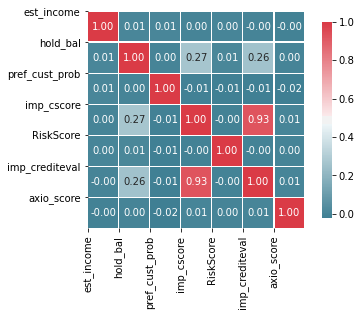

In [9]:
# Draw heatmap
heatMap(data_all[['est_income', 'hold_bal', 'pref_cust_prob', 'imp_cscore', 'RiskScore','imp_crediteval', 'axio_score']])

**<u>Observation:</u>**  
**imp_crediteval** and **imp_cscore** are **highly correlated** (0.93)  
Since these are highly correlated, let's drop one of these column - **dropping imp_crediteval**

## Exploratory Data Analysis

Let's now draw a pair plot between 'est_income', 'hold_bal', 'pref_cust_prob', 'imp_cscore', 'RiskScore', 'axio_score' variables and see how card_offerroutcome varies as these varibales vary

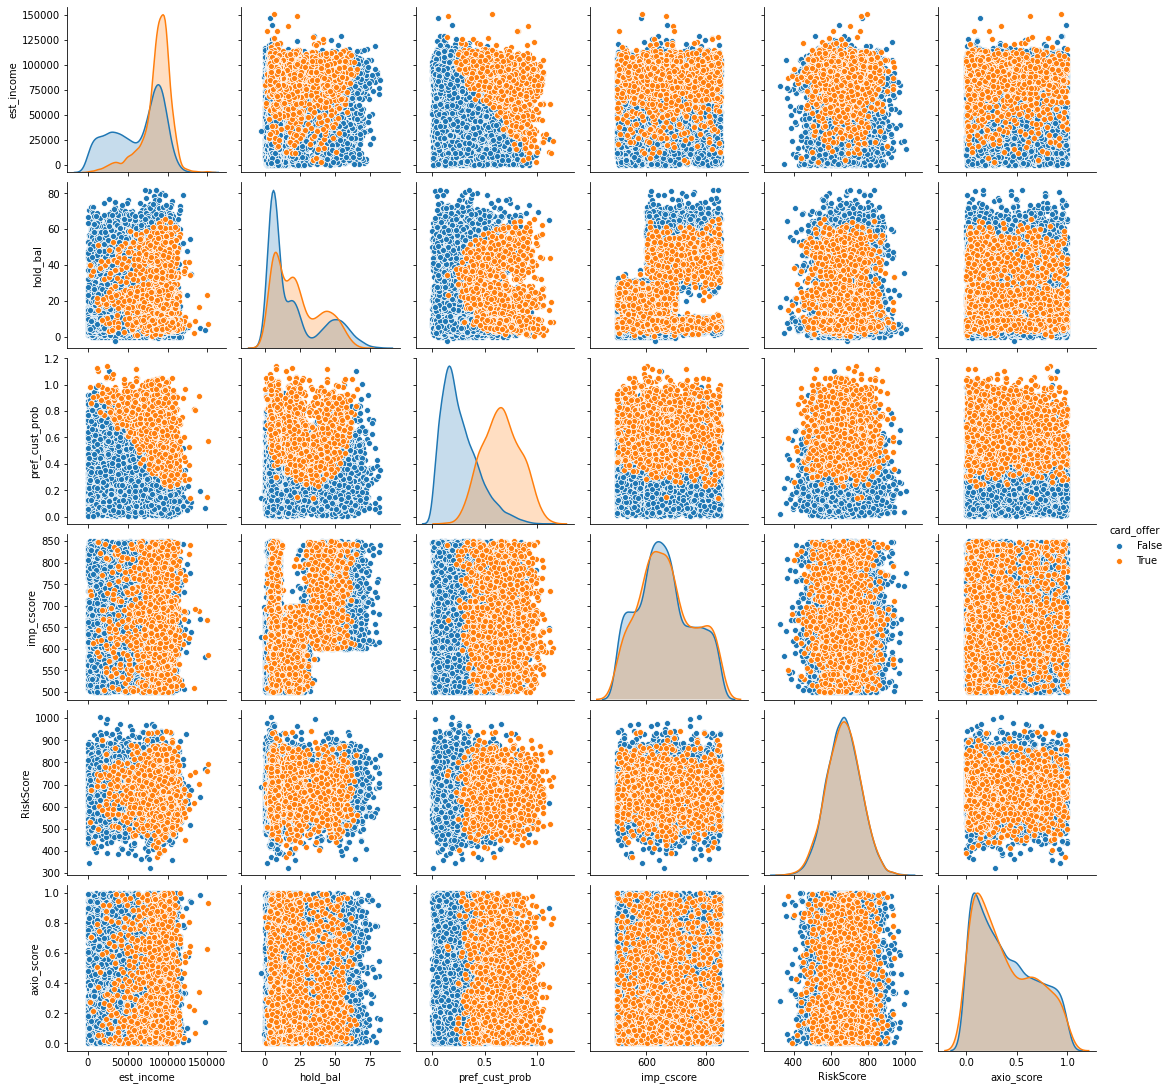

In [10]:
sns.pairplot(data_all, hue="card_offer"
             , vars=['est_income', 'hold_bal', 'pref_cust_prob', 'imp_cscore', 'RiskScore', 'axio_score'])

**Key Observations-**  


*  `pref_cust_prob` when used with any varibale, seems to be segregating target classes effectively
* `pref_cust_prob` combined with `imp_cscore`, `axio_score` or `est_income` seem to be able to separate target classes linearly
* I am not quite sure how `pref_cust_prob` is calculated or gathered in data, it is separating target classes so well and linearly so it looks like we may have a **data leakage** (more specifically **Target leakage** or **leaky predictors**) issue (it basically means that there is a field(s) in training data which is calculated/created after target value is realized, if those fields are included while training model, we would get surprisingly high accuracy on training dataset but would fail big on real world dataset)  
A good refresher on Data Leakage here - https://www.kaggle.com/alexisbcook/data-leakage

Let's check `pref_cust_prob` field a little bit more  



In [11]:
offered_card_prob = data_all.pref_cust_prob[data_all.card_offer]
not_offered_card_prob = data_all.pref_cust_prob[~data_all.card_offer]

print('Mean prob value for those who were offered a card is %.2f , minimum is %.2f and maximum is %.2f' \
      %(offered_card_prob.mean(), offered_card_prob.min(), offered_card_prob.max()))
print('Mean prob value for those who were not offered a card: %.2f , minimum is %.2f and maximum is %.2f' \
      %(not_offered_card_prob.mean(), not_offered_card_prob.min(), not_offered_card_prob.max()))

Mean prob value for those who were offered a card is 0.66 , minimum is 0.14 and maximum is 1.14
Mean prob value for those who were not offered a card: 0.27 , minimum is 0.00 and maximum is 1.11


Mean is `pref_cust_prob` is higher (above 0.5) for the customers who were offered a card but is low for customer who were not offered but these seems to be an overlap too - minimum and maximum values in both cases are close  
We would keep this column for now, but a field like this should be checked further with people who collected/created the data to make sure we do not have potential data leakages. In most situations, it's better to be safe than sorry if you can't track down the people who created the data to find out more.  

**Let's now analyse categorical variables now**  

Plotting country_reg, demographic_slice against card_offer

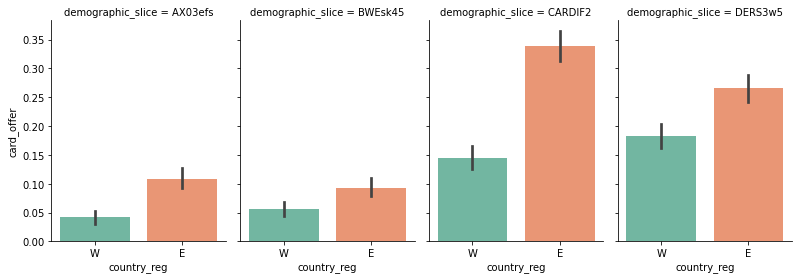

In [12]:
sns.catplot("country_reg","card_offer", data=data_all, col="demographic_slice", kind="bar"
            , aspect=0.7, height=4, palette="Set2")

Checking how _ad\_exp_ affects card_offer

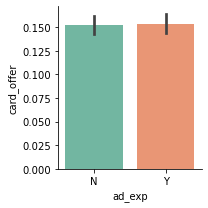

In [13]:
sns.catplot("ad_exp", "card_offer", data=data_all, kind="bar", aspect=1, height=3, palette="Set2")

ad_exp independently seems to have no effect on card_offer values

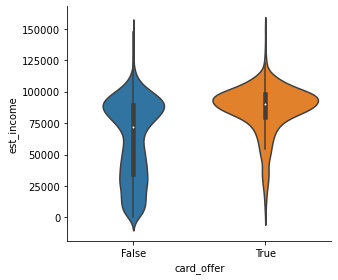

In [14]:
sns.catplot("card_offer", "est_income", data=data_all, kind="violin", inner="box", aspect=1.2, height=4)

Median income of customers who were offered and bought card is more than the ones who were not offered and also from violin graph shape we can get a qualitative ides of that the customers who were offerd card are generally the ones with more income and customers having less income are not offered a card

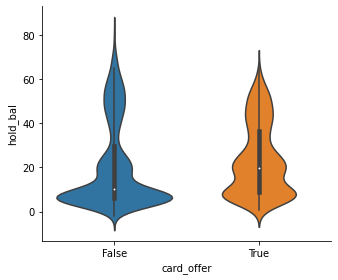

In [15]:
sns.catplot("card_offer", "hold_bal", data=data_all, kind="violin", inner="box", aspect=1.2, height=4)

Customer who were offered cards have high median _hold\_bal_, but in this case both violin graphs looks similar.. in the sense that both have high number of customers with low hold_bal value

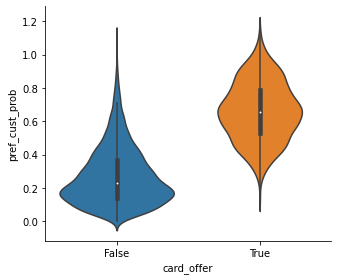

In [16]:
sns.catplot("card_offer", "pref_cust_prob", data=data_all, kind="violin", inner="box", aspect=1.2, height=4)

We can see that little overlap now clearly which we noticed before, otherwise this variable very effectively segregates target classes

## Data Preprocessing

In [17]:
# drop columns
data_all.drop(columns=['customer_id','imp_crediteval'], inplace=True)

In [18]:
# get dummies
category_cols = ['demographic_slice', 'country_reg','ad_exp']
data_all = pd.get_dummies(columns=category_cols, data=data_all, prefix=category_cols, prefix_sep="_",drop_first=True)

In [19]:
# standardize - scale numerical variables (needed for algorithms like Logistic Regression)
scalar = StandardScaler()
num_col_names = ['est_income', 'hold_bal', 'pref_cust_prob', 'imp_cscore', 'RiskScore', 'axio_score']
num_col_df = data_all[num_col_names].copy()
scaled_num_col_df = scalar.fit_transform(num_col_df)
for i,j in enumerate(num_col_names):
    data_all[j] = scaled_num_col_df[:,i]

In [20]:
# convet target column from boolean values to binary values
data_all.at[data_all[data_all['card_offer'] == False].index, 'card_offer'] = 0
data_all.at[data_all[data_all['card_offer'] == True].index, 'card_offer'] = 1

Verify that all numerical columns are successfully scaled, we will take a peek into first five rows

In [21]:
data_all.head()

,est_income,hold_bal,pref_cust_prob,imp_cscore,RiskScore,axio_score,card_offer,demographic_slice_BWEsk45,demographic_slice_CARDIF2,demographic_slice_DERS3w5,country_reg_W,ad_exp_Y
0,-1.043537,-0.953421,0.903285,-0.480961,-1.854061,-0.887913,0,0,0,0,1,0
1,-1.477103,-0.037404,-0.143226,-1.497025,1.668108,-1.182904,0,0,0,0,0,0
2,-0.470570,-0.900343,-1.392624,-0.624535,-0.927477,0.204086,0,0,0,0,1,1
3,0.043685,-0.122557,-1.075184,-0.856463,-0.392845,0.594694,0,0,0,0,0,1
4,-1.471770,-0.900343,-1.050087,-1.055258,-0.423436,1.818321,0,0,0,0,1,0


## Data Modeling

We will split the dataset in to train and test sets , we will follow a 7:3 split  
**Imp:-** stratify on 'card_offer' field while splitting. Since our classes are imbalanced it is important that we have equal proportion of classes in both training and test sets

In [22]:
# Train and Test
X,y = data_all.loc[:,data_all.columns != 'card_offer'], data_all.loc[:,data_all.columns == 'card_offer'].astype('int')
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=42, stratify=data_all['card_offer'])

In [23]:
y_train['card_offer'].unique(), X_train.shape

(array([0, 1]), (7000, 11))

In [24]:
classifier = LogisticRegression(random_state=42, solver='lbfgs')

In [25]:
classifier.fit(X_train, y_train)
y_train_pred = classifier.predict(X_train)
y_train_pos_prob = classifier.predict_proba(X_train)[:, 1]
y_test_pred = classifier.predict(X_test)
y_test_pos_prob = classifier.predict_proba(X_test)[:, 1]

In [26]:
print("Train AUC ROC   %.3f" % roc_auc_score(y_train, y_train_pred))
print("Train Precision %.3f" % precision_score(y_train, y_train_pred))
print("Train Recall    %.3f" % recall_score(y_train, y_train_pred))
print("Train F1 Score  %.3f" % f1_score(y_train, y_train_pred))
print("--\n")
print("Test AUC ROC   %.3f" % roc_auc_score(y_test, y_test_pred))
print("Test Precision %.3f" % precision_score(y_test, y_test_pred))
print("Test Recall    %.3f" % recall_score(y_test, y_test_pred))
print("Test F1 Score  %.3f" % f1_score(y_test, y_test_pred))

Train AUC ROC   0.925
Train Precision 0.899
Train Recall    0.868
Train F1 Score  0.883
--

Test AUC ROC   0.913
Test Precision 0.900
Test Recall    0.843
Test F1 Score  0.871


Text(0.5, 1.0, 'Test PR Curve')

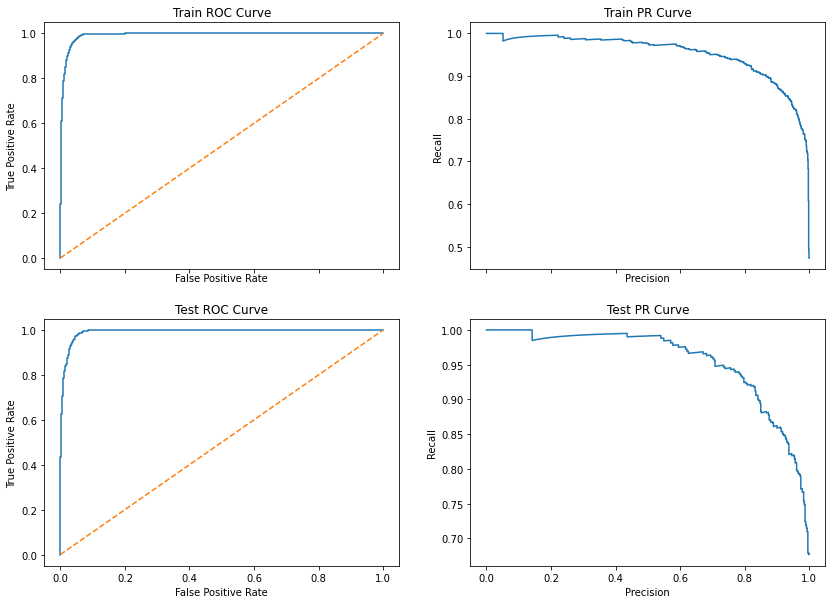

In [27]:
# calculating False Positive Rate and True Positive Rate for plotting ROC Curve
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pos_prob)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pos_prob)

# calculating Precision and Recall values
p_train, r_train, _ = precision_recall_curve(y_train, y_train_pos_prob)
p_test, r_test, _ = precision_recall_curve(y_test, y_test_pos_prob)


fig, axs = plt.subplots(2,2, sharex=True, figsize=(14,10))

axs[0,0].plot(fpr_train, tpr_train, label="Model Output")
axs[0,0].plot([0,1], [0,1], linestyle='--', label='No learning')
axs[0,0].set(xlabel='False Positive Rate', ylabel='True Positive Rate')
axs[0,0].set_title('Train ROC Curve')

axs[1,0].plot(fpr_test, tpr_test, label="Model Output")
axs[1,0].plot([0,1], [0,1], linestyle='--', label='No learning')
axs[1,0].set(xlabel='False Positive Rate', ylabel='True Positive Rate')
axs[1,0].set_title('Test ROC Curve')

axs[0,1].plot(r_train, p_train)
axs[0,1].set(xlabel='Precision', ylabel='Recall')
axs[0,1].set_title('Train PR Curve')

axs[1,1].plot(r_test, p_test)
axs[1,1].set(xlabel='Precision', ylabel='Recall')
axs[1,1].set_title('Test PR Curve')

## SMOTE

One of the approach to address imbalanced datasets is to oversample the minority class. The simplest approach could be duplicating examples in the minority class, although these examples don’t add any new information to the model. Instead, new examples can be synthesized from the existing examples. This is a type of data augmentation for the minority class and is referred to as the **Synthetic Minority Oversampling Technique**, or **SMOTE** for short.



> *SMOTE works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line.  
Specifically, a random example from the minority class is first chosen. Then k of the nearest neighbors for that example are found (typically k=5). A randomly selected neighbor is chosen and a synthetic example is created at a randomly selected point between the two examples in feature space.*

Heare two great links for learning more about SMOTE
1. Link to original paper - https://arxiv.org/abs/1106.1813
2. Detailed blog explaining various techniques with examples - https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

In [28]:
# We are first oversampling minority (positive) classes and changing the ratio from 0.15:0.85 (or 1.176:0.1) to 0.3:1
over = SMOTE(sampling_strategy=0.3, random_state=42)

# We are now undersampling majority (negative) classes and changing the ratio from 0.3:1 to 0.5:1 i.e 1:2 ratio for minority and majority classes
under = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
steps = [('over', over), ('under', under), ('classifier', classifier)]
pipeline = Pipeline(steps=steps)

pipeline.fit(X_train, y_train)
y_train_pred = pipeline.predict(X_train)
y_train_pos_prob = pipeline.predict_proba(X_train)[:, 1]
y_test_pred = pipeline.predict(X_test)
y_test_pos_prob = pipeline.predict_proba(X_test)[:, 1]

In [29]:
print("Train AUC ROC   %.3f" % roc_auc_score(y_train, y_train_pred))
print("Train Precision %.3f" % precision_score(y_train, y_train_pred))
print("Train Recall    %.3f" % recall_score(y_train, y_train_pred))
print("Train F1 Score  %.3f" % f1_score(y_train, y_train_pred))
print("\n")
print("Test AUC ROC   %.3f" % roc_auc_score(y_test, y_test_pred))
print("Test Precision %.3f" % precision_score(y_test, y_test_pred))
print("Test Recall    %.3f" % recall_score(y_test, y_test_pred))
print("Test F1 Score  %.3f" % f1_score(y_test, y_test_pred))

Train AUC ROC   0.956
Train Precision 0.841
Train Recall    0.945
Train F1 Score  0.890


Test AUC ROC   0.952
Test Precision 0.843
Test Recall    0.935
Test F1 Score  0.886


## Final Comments
* We have got around 4.3% improvement in ROC-AUC on Test set
* 1.7% improvement in F1-Score
* 10.9% improvement in Recall but 6.3% drop in precision score - There is always a trade-off between precision and recall and one increases at the cost of other. Overall, we have been able to improve F1-Score and our model and also able to improve Recall which is what we wanted for this model
* Our ROC, F1 were already very high even before implementing SMOTE and so it didn't result in significant improvement over original but the goal of this kernel was to show how we can use SMOTE to handle imbalanced data and improve our predictions and I hope I was able to achieve that44

<hr>